<a href="https://colab.research.google.com/github/PGoyal-06/Computer_Vision/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's exisiting architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt to those patterns to our own data

In [ ]:
!nvidia-smi

Wed Oct  4 23:51:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-10-04 23:51:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  30.1MB/s    in 6.4s    

2023-10-04 23:51:46 (25.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' . ")

There are 2 directories and 0 images in '10_food_classes_10_percent' . 
There are 10 directories and 0 images in '10_food_classes_10_percent/test' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak' . 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream' . 
There are 0 directories and 250 images in '10_food_

## Creating data loaders (preparing the data)

we'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing  images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing  images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create tensorflow callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter created above is only one option

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

In [ ]:
# Compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a keras Sequential model with i.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to numbmer of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # create our own model
  model_1 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model_1

### Creating and tetsing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# compile the  model
resnet_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [ ]:
# Let's fit our resnet model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231004-235206
Epoch 1/5
24/24 [==============================] - 25s 534ms/step - loss: 1.8606 - accuracy: 0.3893 - val_loss: 1.1816 - val_accuracy: 0.6236
Epoch 2/5
24/24 [==============================] - 11s 467ms/step - loss: 0.8681 - accuracy: 0.7560 - val_loss: 0.8667 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 11s 484ms/step - loss: 0.6127 - accuracy: 0.8307 - val_loss: 0.7474 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 10s 433ms/step - loss: 0.4608 - accuracy: 0.8800 - val_loss: 0.6945 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 11s 448ms/step - loss: 0.3729 - accuracy: 0.9187 - val_loss: 0.6771 - val_accuracy: 0.7828


In [ ]:
# Create a function to plot loss curves
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history; TensorFlow History object.

    Returns:
      Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

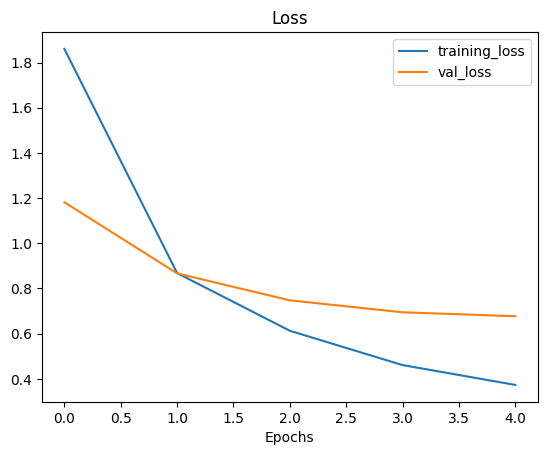

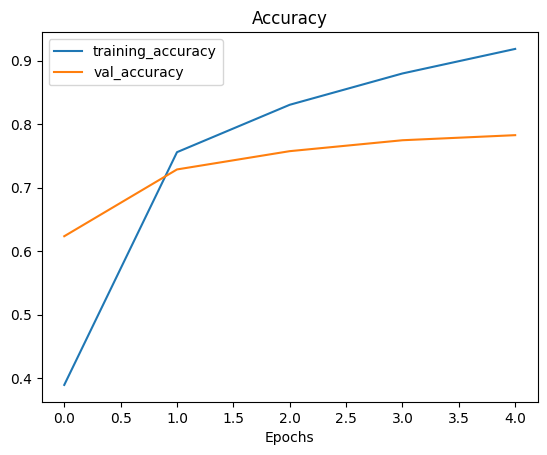

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# create efficientnetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history =  efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data_10_percent,
                                               validation_steps=len(test_data_10_percent),
                                               callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20231004-235346
Epoch 1/10
24/24 [==============================] - 22s 508ms/step - loss: 1.8661 - accuracy: 0.4387 - val_loss: 1.3258 - val_accuracy: 0.7104
Epoch 2/10
24/24 [==============================] - 10s 434ms/step - loss: 1.0850 - accuracy: 0.7560 - val_loss: 0.8854 - val_accuracy: 0.8120
Epoch 3/10
24/24 [==============================] - 11s 456ms/step - loss: 0.7793 - accuracy: 0.8280 - val_loss: 0.7045 - val_accuracy: 0.8400
Epoch 4/10
24/24 [==============================] - 9s 406ms/step - loss: 0.6226 - accuracy: 0.8640 - val_loss: 0.6167 - val_accuracy: 0.8552
Epoch 5/10
24/24 [==============================] - 10s 439ms/step - loss: 0.5282 - accuracy: 0.8880 - val_loss: 0.5598 - val_accuracy: 0.8624
Epoch 6/10
24/24 [==============================] - 10s 425ms/step - loss: 0.4578 - accuracy: 0.9013 - val_loss: 0.5195 - val_accuracy: 0.8672
Epoch 7/10
24/24 [==============================] - 10s 424ms/st

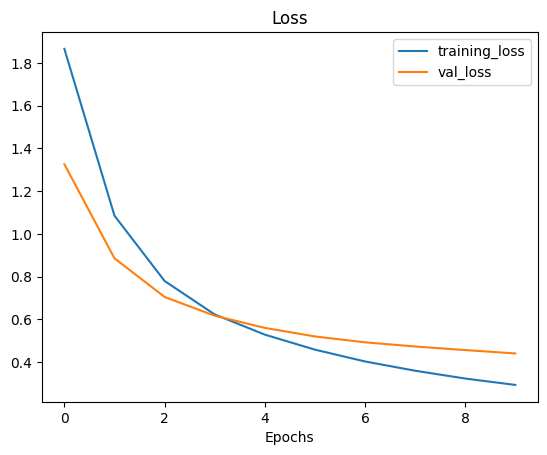

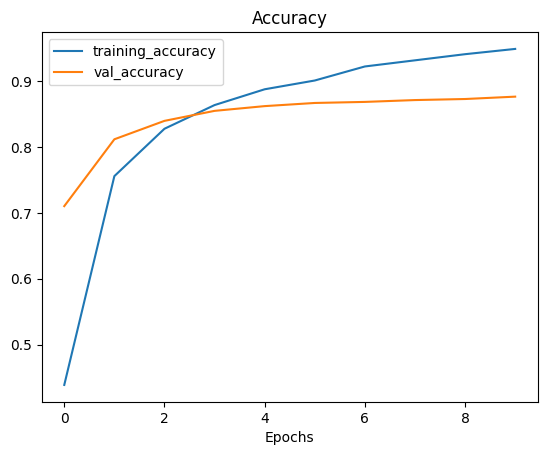

In [ ]:
plot_loss_curves(efficientnet_history)

## DIfferent Types of transfer learning

* **"As is" transfer learning** - using an existing modle with no changes whatsoever
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing model results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments, do not upload them to TensorBoard.dev  

In [ ]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-10-05 00:26:42.112627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VBZM-VVYQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/KjGNHnTmT56bnbTe5Tns0A/

In [ ]:
# check out what tensorboard experiments you have
!tensorboard dev list

2023-10-05 00:30:54.217752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/KjGNHnTmT56bnbTe5Tns0A/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   KjGNHnTmT56bnbTe5Tns0A
	Created              2023-10-05 00:27:15 (3 minutes ago)
	Updated              2023-10-05 00:27:20 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  6185613
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id KjGNHnTmT56bnbTe5Tns0A